In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim  

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# Load training data 
train_data = datasets.CIFAR10(
    root = "data",              
    train = True,               
    transform = ToTensor(),     
    download = True             
)

# Load test data (10,000 images to evaluate model)
test_data = datasets.CIFAR10(
    root = "data",              
    train = False,              
    transform = ToTensor(),     
    download = True             
)

In [3]:

loaders = {
    # Training loader - feeds 100 images at a time during training
    "train": DataLoader(
        train_data,           
        batch_size = 100,     
        shuffle = True,       
        num_workers = 1       
    ),
    
    # Test loader - feeds 100 images at a time during testing
    "test": DataLoader(
        test_data,            
        batch_size = 100,     
        shuffle = True,       
        num_workers = 1       
    )
}

In [4]:
# Define CNN class for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)        
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))           
        x = F.max_pool2d(x, 2)              
        
        x = F.relu(self.conv2(x))           
        x = F.max_pool2d(x, 2)              
        
        x = F.relu(self.conv3(x))           
        x = F.max_pool2d(x, 2)              
        
        x = x.view(-1, 128 * 4 * 4)
        
        x = F.relu(self.fc1(x))             
        x = self.dropout(x)                 
        
        x = self.fc2(x)
        
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [6]:
# Function to train the model for one epoch
def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                  f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

# Function to test model accuracy on test data
def test():
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(loaders["test"].dataset)} ({accuracy:.2f}%)\n')

In [8]:
# Train for 20 epochs 
for epoch in range(1, 20):
    train(epoch)  
    test()       

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301597
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.723871
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.761026
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.540577
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.431988

Test set: Average loss: 1.3147, Accuracy: 5192/10000 (51.92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.324273
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.325147
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.432557
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.194553
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.354640

Test set: Average loss: 1.0782, Accuracy: 6125/10000 (61.25%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.368178
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.117942
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.074106
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.059405
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.935172

Test set: Average loss: 0.9944, Accuracy: 6424/10000 (64.24%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.002016
Train Epoch: 4 [10000/50000 

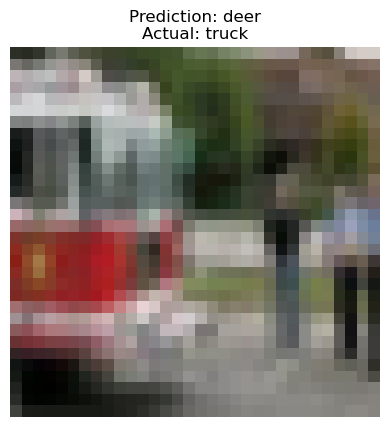

Model predicted: deer
Actual label: truck


In [9]:
# Get one batch of test data
data_iter = iter(loaders['test'])
images, labels = next(data_iter)

# CIFAR-10 class names
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()

with torch.no_grad():
    image = images[8].to(device)
    output = model(image.unsqueeze(0))
    prediction = output.argmax(dim=1).item()

# Display the image
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f'Prediction: {classes[prediction]}\nActual: {classes[labels[0]]}')
plt.axis('off')
plt.show()

print(f'Model predicted: {classes[prediction]}')
print(f'Actual label: {classes[labels[0]]}')